## Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *

## Getting and converting the data

In [10]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [16]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [6]:
fname = '09/frame_00667_rgb.jpg'

In [14]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

In [8]:
img2txt_name(fname)

PosixPath('/home/paperspace/.fastai/data/biwi_head_pose/09/frame_00667_pose.txt')

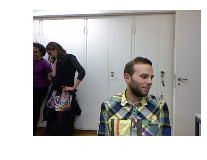

In [9]:
img = open_image(path/fname)
img.show()

In [14]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [12]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [5]:
doc(ImagePoints)

Show the image `img` opened above with a dot in the center of the person's face.

## Creating a dataset

Create a `PointsItemList` using the data block API. Split by a validation function that checks if the parent directory's name is `13`. Label them using the function `get_ctr`. Transform using a basic `get_transforms()`, and remember to transform `y` as well. Size should be `(120,160)`. Create a databunch and normalize it using the imagenet stats. 

In [17]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

Show a batch over 3 rows with a figsize of `(9,6)`.

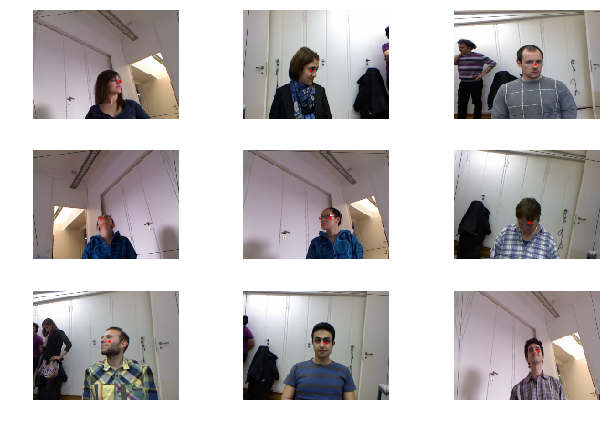

In [18]:
data.show_batch(3, figsize=(9,6))

## Train model

Create a CNN w/ resnet34 architecture.

In [21]:
learn = cnn_learner(data, models.resnet34)

Find a learning rate. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


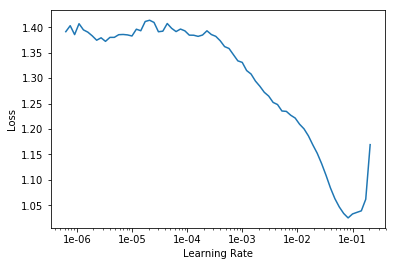

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
lr = 2e-2

Fit a 5-epoch cycle.

In [24]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
1,0.049281,0.012704,00:49
2,0.017486,0.006519,00:48
3,0.008655,0.001681,00:48
4,0.005066,0.000512,00:48
5,0.003864,0.000698,00:48


Save the weights and immediately load them back again.

In [25]:
learn.save('stage-1')

In [26]:
learn.load('stage-1');

Show the results of the learner.

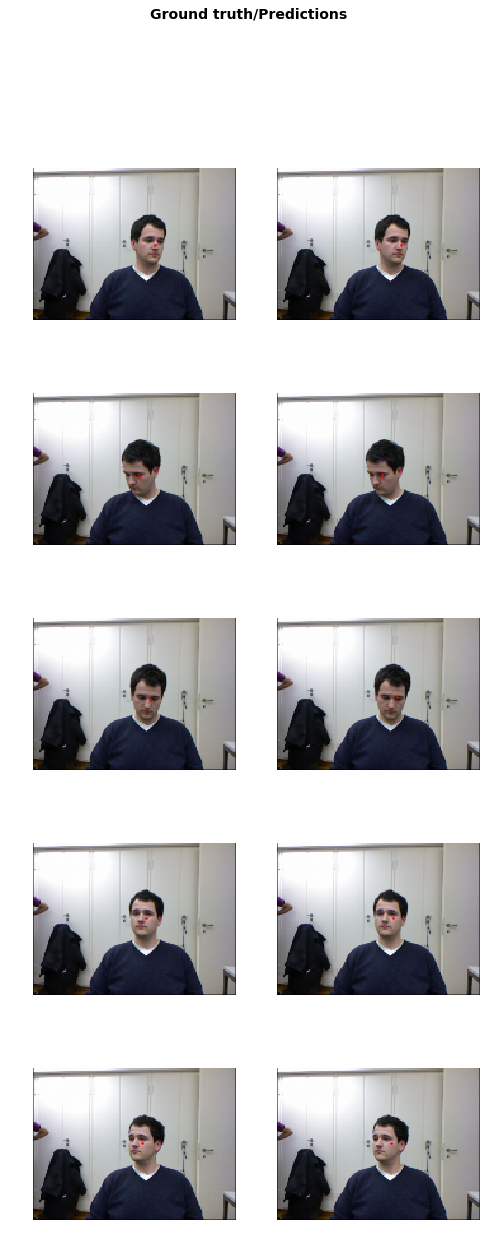

In [27]:
learn.show_results()

## Data augmentation

Get transforms with the following specs:
* max_rotate=20
* max_zoom=1.5
* max_lighting=0.5
* max_warp=0.4
* p_affine=1.
* p_lighting=1.

In [19]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

Create a PointsItemList in the same way you did last time.

In [29]:
doc(PointsItemList)

Create a function `_plot` that takes arguments `i`, `j` and `ax`, and calls `x.show(ax, y=y)`. 

Use the `plot_multi` method to plot a single example 9x across a 3x3 grid with each instance having different image augmentation parameters.

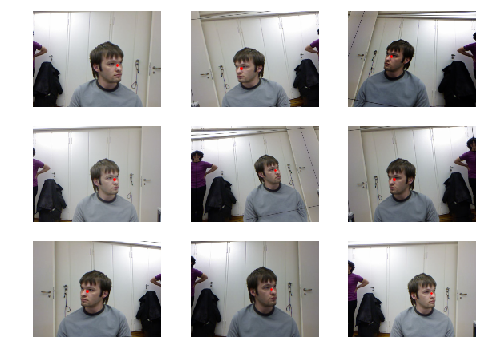

In [30]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))